This is the final part of my CNN series for detecting respiratory diseases using respiratory sound. On this kernel, we use the images created from audio to feed to a convolutional 2d model, in this case, I'm using VGG16.

If you missed out on how we manipulate and transformed out data, you can look through these kernels:
- Part 1: [Slice audio into subslices based on the txt files](https://www.kaggle.com/danaelisanicolas/cnn-part-1-create-subslices-for-each-sound)
- Part 2: [Splitting to train and test](https://www.kaggle.com/danaelisanicolas/cnn-part-2-split-to-train-and-test)
- Part 3: [Convert audio to spectrogram images](https://www.kaggle.com/danaelisanicolas/cnn-part-3-create-spectrogram-images)

Without further adeu, let's start!

In [1]:
!ls '../input'

respiratory-sound-database  specimages


Import the necessary libraries. Here we're using TensorFlow Keras. Again as mentioned, we'll use VGG16.

In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [3]:
train_loc = '../input/specimages/train_test_split/train/'
test_loc = '../input/specimages/train_test_split/val/'

Load the train and test data using ImageDataGenerator flow_from_directory. Target size set to 224x224 given that this is the input requirement of VGG16.

In [4]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 5515 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [5]:
diagnosis_csv = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [6]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

Use the weights from imagenet to get the pretrained model. The prediction is set to 8 output because we have 8 classes.

In [7]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=8, activation="softmax"))

In [8]:
opt = Adam(lr=0.0000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy', 'mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 802816)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                51380288  
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 51,400,200
Trainable params: 51,400,200
Non-trainable params: 0
____________________________________________

Now we also want to save the model if the validation accuracy improved. However, we don't want to waste computational resource if we're seeing the lack of improvement after 20 epochs.

We then define the checkpoint and early stopping for our model.

In [9]:
checkpoint = ModelCheckpoint("res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=35, verbose=1, mode='auto')

Now, considering our data is imbalanced, we need to compute the class weight for each category/class.

In [10]:
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1149.0,
 1: 55.373493975903614,
 2: 35.90625,
 3: 1.0,
 4: 17.883268482490273,
 5: 183.84,
 6: 20.157894736842106,
 7: 23.690721649484537}

Finally everything's set, let's start training!

Notice that steps_per_epoch and validation_steps were calculated instead of just simply setting a random value. The reason is we need to see the optimal way to getting these values. We calculate this by dividing samples / batch_size.

In [11]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=125,callbacks=[checkpoint,early])

Train for 172 steps, validate for 43 steps
Epoch 1/125
171/172 [============================>.] - ETA: 0s - loss: 67.7333 - accuracy: 0.1137 - mae: 0.2222
Epoch 00001: val_accuracy improved from -inf to 0.23474, saving model to res.h5
172/172 [==============================] - 86s 498ms/step - loss: 67.4486 - accuracy: 0.1147 - mae: 0.2220 - val_loss: 32.6043 - val_accuracy: 0.2347 - val_mae: 0.1956
Epoch 2/125
171/172 [============================>.] - ETA: 0s - loss: 32.8427 - accuracy: 0.2185 - mae: 0.1965
Epoch 00002: val_accuracy improved from 0.23474 to 0.32631, saving model to res.h5
172/172 [==============================] - 63s 368ms/step - loss: 32.7297 - accuracy: 0.2198 - mae: 0.1963 - val_loss: 55.1550 - val_accuracy: 0.3263 - val_mae: 0.1700
Epoch 3/125
171/172 [============================>.] - ETA: 0s - loss: 36.9789 - accuracy: 0.2383 - mae: 0.1928
Epoch 00003: val_accuracy did not improve from 0.32631
172/172 [==============================] - 62s 359ms/step - loss: 3

And lastly we want to visualise how our model is learning. Plot the loss, accuracy, and mae as follows:

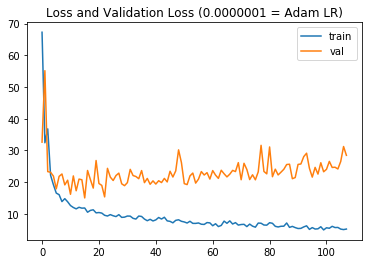

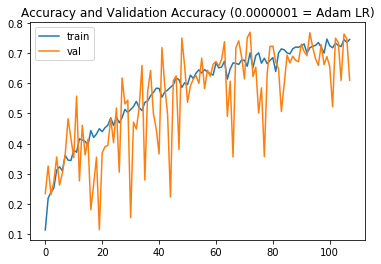

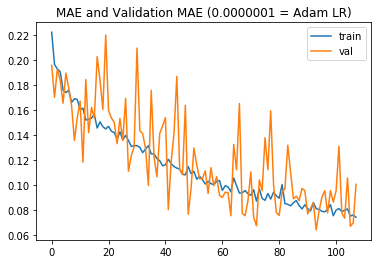

In [12]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Loss and Validation Loss (0.0000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Accuracy and Validation Accuracy (0.0000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('MAE and Validation MAE (0.0000001 = Adam LR)')
plt.legend();
plt.show()

We see that slowly but surely our model is learning our data. Validation accuracy is increasing steadily while mean absolute error is decreasing. However, we should be aware that loss is increasing. In this context, but maybe we can just ditch loss since we are already looking at mae.

And that's that! If you're following this series, thank you so much! Please upvote if this helped you in any way.
